In [1]:
from icecream import ic

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# load Leogrin/eleuther-pythia1b-hh-dpo

def load_model(model_size, model_type):
        if model_type == "sft_trlx":
            user = "yonzx"
            model_dpo = AutoModelForCausalLM.from_pretrained(f"yonzx/eleuther-pythia-{model_size}-sft-hh")
        else:
            if model_size in ["1b", "1.4b"]:
                user = "leogrin"
            else:
                user = "lomahony"

            model_dpo = AutoModelForCausalLM.from_pretrained(f"{user}/eleuther-pythia{model_size}-hh-{model_type}")
        return model_dpo

        

In [3]:
import pickle
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

# Generate completions

In [ ]:
from preference_datasets import get_batch_iterator
def generate_completions(model_size, model_type, split="train", n_samples=6_000):
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

    dataloader = get_batch_iterator(["hh"], tokenizer, batch_size=16, shuffle=True, n_examples=n_samples)
    
    model = load_model(model_size, model_type)
    model.cuda()
    model.eval()


    all_generated = []

    # generate completions
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["prompt_input_ids"].cuda()
            attention_mask = batch["prompt_attention_mask"].cuda()
            generated = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=150, do_sample=True)
            all_generated.extend(generated.cpu().numpy().tolist())

    
    # save completions tokenized
    with open(f"completions_{model_size}_{model_type}_{split}.pkl", "wb") as f:
        pickle.dump(all_generated, f)
    

In [ ]:
# Submit the task using submitit
import submitit
executor = submitit.AutoExecutor(folder="submitit_jobs/")
executor.update_parameters(
    timeout_min=60,  # Set to the max runtime of your job
    slurm_partition="parietal,normal,gpu",  # Specify a default partition
    gpus_per_node=1,
    exclude="margpu001,margpu002,margpu003,margpu004"
)

model_sizes = ["70m", "160m", "410m", "1b", "1.4b"]
model_types = ["sft", "dpo"]#["sft_trlx"]
splits = ["train", "test"]

for model_size in model_sizes:
    for model_type in model_types:
        for split in splits:
            executor.submit(generate_completions, model_size=model_size, model_type=model_type, split=split)


# Compute rewards

In [4]:
from datasets import Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from itertools import dropwhile
import torch

from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch

def pad_collate(batch):
    processed_batch = []
    max_length = 0
    
    # Step 1: Removing left padding (value 0) and finding the max length
    for sample in batch:
        input_ids = sample['input_ids']
        non_zero_idx = (input_ids != 0).nonzero(as_tuple=True)[0]
        if non_zero_idx.size(0) == 0:  # In case the sequence has all zeros
            non_zero_idx = input_ids.size(0)
        else:
            non_zero_idx = non_zero_idx[0]
        trimmed_input_ids = input_ids[non_zero_idx:]
        max_length = max(max_length, len(trimmed_input_ids))
        sample['input_ids'] = trimmed_input_ids
        processed_batch.append(sample)
    
    # Step 2: Adding right padding (value 1)
    for sample in processed_batch:
        input_ids = sample['input_ids']
        pad_length = max_length - len(input_ids)
        padded_seq = torch.cat((input_ids, torch.ones(pad_length, dtype=torch.long)), dim=0)
        sample['input_ids'] = padded_seq

    return processed_batch

class CustomDataset(Dataset):
    def __init__(self, input_data, max_length):
        self.input_data = input_data
        self.max_length = max_length

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        item = self.input_data[idx]

        # Remove left padding (zeros)
        item = list(dropwhile(lambda x: x == 0, item))
        # Remove right padding (zeros)
        item = item[::-1]  # reverse the list
        item = list(dropwhile(lambda x: x == 0, item))
        item = item[::-1]  # reverse the list to original order
        item.append(0)  # add back one zero (eos token)
        # Right pad with ones
        item_length = len(item)
        item = item + [1] * (self.max_length - item_length)
        
        return torch.tensor(item, dtype=torch.long), torch.tensor(item_length, dtype=torch.long)

def compute_rewards_from_completions(model_size, model_type, split="train"):
    # load completions
    with open(f"completions_{model_size}_{model_type}_{split}.pkl", "rb") as f:
        all_generated = pickle.load(f)


    # Create an instance of the CustomDataset with max_length parameter
    dataset = CustomDataset(all_generated, max_length=1024)

    # Create a DataLoader from the dataset
    generated_dataloader = DataLoader(dataset, batch_size=2, shuffle=False)


    # make a dataloader from the dataset
    #generated_dataloader = torch.utils.data.DataLoader(generated_dataset, shuffle=False, batch_size=2, collate_fn=pad_collate)

    # compute the reward
    rm_model = AutoModelForSequenceClassification.from_pretrained("usvsnsp/pythia-6.9b-rm-full-hh-rlhf")
    rm_model.eval()
    rm_model.cuda()

    # compute mean reward
    from tqdm.auto import tqdm

    all_rewards = []
    for batch in tqdm(generated_dataloader):
        input_ids, _ = batch
        input_ids = input_ids.cuda()
        with torch.no_grad():
            outputs = rm_model(input_ids=input_ids)
            rewards = outputs.logits
            all_rewards.extend(rewards.cpu().numpy().tolist())
        if (len(all_rewards) // 2) % 10:
            print(f"mean reward: {np.mean(all_rewards)}")
            print(f"median reward: {np.median(all_rewards)}")
        if len(all_rewards) >= 1000:
            break
    
    # save rewards
    with open(f"rewards_{model_size}_{model_type}_{split}.pkl", "wb") as f:
        pickle.dump(all_rewards, f)



In [7]:
# Submit the task using submitit
import submitit
executor = submitit.AutoExecutor(folder="submitit_jobs/")
executor.update_parameters(
    timeout_min=300,  # Set to the max runtime of your job
    slurm_partition="parietal,normal,gpu",  # Specify a default partition
    gpus_per_node=1,
    exclude="margpu001,margpu002,margpu003,margpu004"
)

model_sizes = ["70m", "160m", "410m", "1b", "1.4b"]
model_types = ["dpo", "sft"]
splits = ["train", "test"]

for model_size in model_sizes:
    for model_type in model_types:
        for split in splits:
            executor.submit(compute_rewards_from_completions, model_size=model_size, model_type=model_type, split=split)
            

/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Define the model sizes and types
model_sizes = ["70m", "160m", "410m", "1b", "1.4b"]  # Replace with the actual sizes you're using
model_types = ["sft", "dpo"]

# make into a dataframe
import pandas as pd
df = pd.DataFrame(columns=["model_size", "model_type", "split", "reward"])
for model_size in model_sizes:
    for model_type in model_types:
        for split in ["train", "test"]:
            with open(f"rewards_{model_size}_{model_type}_{split}.pkl", "rb") as f:
                all_rewards = pickle.load(f)
                for reward in all_rewards:
                    df = pd.concat([df, pd.DataFrame({"model_size": model_size, "model_type": model_type, "split": split, "reward": reward}, index=[0])])

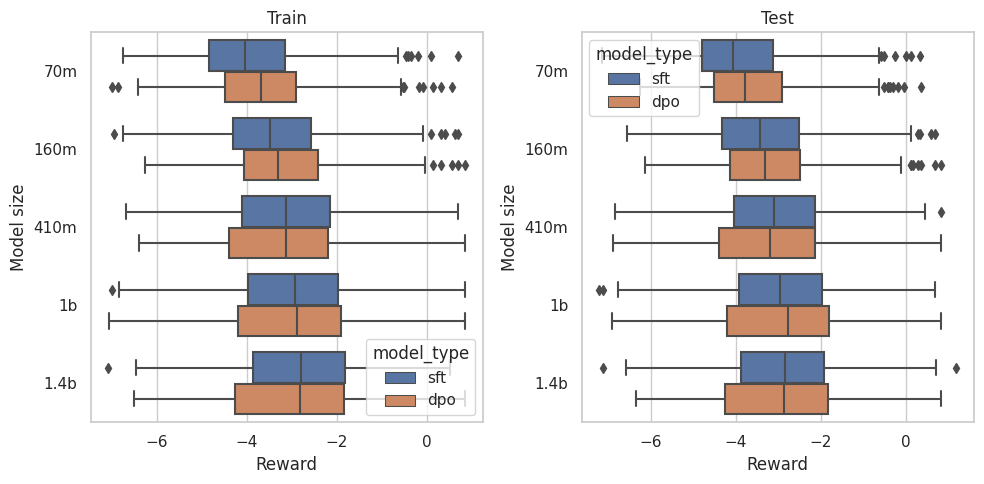

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")
# two subplots for train and test
#ax = sns.boxplot(y="model_size", x="reward", hue="model_type", data=df, palette="Set3")
# train
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y="model_size", x="reward", hue="model_type", data=df[df["split"] == "train"], ax=ax[0])
# plot the mean
ax[0].set_title("Train")
ax[0].set_xlabel("Reward")
ax[0].set_ylabel("Model size")
# test
sns.boxplot(y="model_size", x="reward", hue="model_type", data=df[df["split"] == "test"], ax=ax[1])
ax[1].set_title("Test")
ax[1].set_xlabel("Reward")
ax[1].set_ylabel("Model size")
plt.tight_layout()

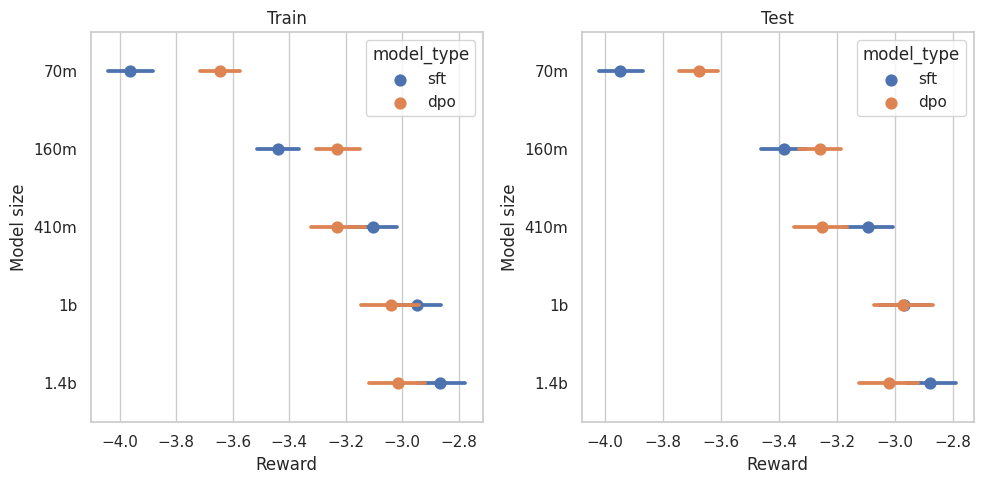

In [3]:
# plot only the mean and uncertainty
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.pointplot(y="model_size", x="reward", hue="model_type", data=df[df["split"] == "train"], ax=ax[0], errorbar="ci", linestyles="")
# plot the mean
ax[0].set_title("Train")
ax[0].set_xlabel("Reward")
ax[0].set_ylabel("Model size")
# test
sns.pointplot(y="model_size", x="reward", hue="model_type", data=df[df["split"] == "test"], ax=ax[1], errorbar="ci", linestyles="")
ax[1].set_title("Test")
ax[1].set_xlabel("Reward")
ax[1].set_ylabel("Model size")
plt.tight_layout()

# Look at the completions

In [ ]:
import pickle
import torch
from datasets import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch import nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from icecream import ic
from itertools import dropwhile

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
tokenizer.pad_token = tokenizer.eos_token

model_size = "160m"

with open(f"completions_{model_size}_dpo_train.pkl", "rb") as f:
    all_generated_dpo = pickle.load(f)
generated_dataset_dpo = Dataset.from_dict({"input_ids": all_generated_dpo})

with open(f"rewards_{model_size}_dpo_train.pkl", "rb") as f:
    all_rewards_dpo = pickle.load(f)

with open(f"completions_{model_size}_sft_train.pkl", "rb") as f:
    all_generated_sft = pickle.load(f)
generated_dataset_sft = Dataset.from_dict({"input_ids": all_generated_sft})

with open(f"rewards_{model_size}_sft_train.pkl", "rb") as f:
    all_rewards_sft = pickle.load(f)


with torch.no_grad():
    for i in range(100):
        ic("--------------------------------------------")
        ic("prompt:")
        ic(tokenizer.decode(generated_dataset_dpo[i]["input_ids"], skip_special_tokens=False).rsplit("\n\nAssistant:", 1)[0] +"\n\nAssistant:")
        ic(f"DPO, reward: {all_rewards_dpo[i]}")
        ic(tokenizer.decode(generated_dataset_dpo[i]["input_ids"], skip_special_tokens=False).rsplit("\n\nAssistant:", 1)[1])
        ic("-------")
        ic(f"SFT, reward: {all_rewards_sft[i]}")
        ic(tokenizer.decode(generated_dataset_sft[i]["input_ids"], skip_special_tokens=False).rsplit("\n\nAssistant:", 1)[1])
        ic()

Found cached dataset json (/scratch/lgrinszt/Anthropic___json/Anthropic--hh-rlhf-a9fdd36e8b50b8fa/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 160800/160800 [00:32<00:00, 4996.41it/s]


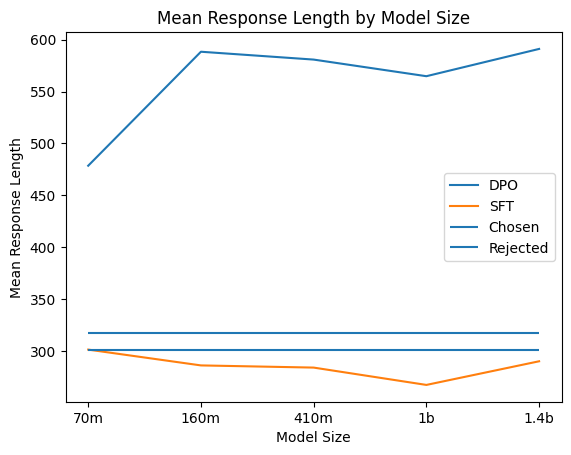

In [35]:
import pickle
from datasets import Dataset
import matplotlib.pyplot as plt

# import hh dataset
from tqdm import tqdm
from datasets import load_dataset
hh_dataset = load_dataset('Anthropic/hh-rlhf', split='train')
# compute mean length of response for chosen and rejected completions
chosen_lengths = []
rejected_lengths = []
for i in tqdm(range(len(hh_dataset))):
    chosen_lengths.append(len(hh_dataset[i]["chosen"].rsplit("\n\nAssistant:", 1)[1]))
    rejected_lengths.append(len(hh_dataset[i]["rejected"].rsplit("\n\nAssistant:", 1)[1]))

model_sizes = ["70m", "160m", "410m", "1b", "1.4b"]

mean_dpo_lengths = []
mean_sft_lengths = []

for model_size in model_sizes:
    with open(f"completions_{model_size}_dpo_train.pkl", "rb") as f:
        all_generated_dpo = pickle.load(f)
    generated_dataset_dpo = Dataset.from_dict({"input_ids": all_generated_dpo})

    with open(f"completions_{model_size}_sft_train.pkl", "rb") as f:
        all_generated_sft = pickle.load(f)
    generated_dataset_sft = Dataset.from_dict({"input_ids": all_generated_sft})

    dpo_lengths = [len(tokenizer.decode(generated_dataset_dpo[i]["input_ids"], skip_special_tokens=True).rsplit("\n\nAssistant:", 1)[1]) for i in range(len(generated_dataset_dpo))]
    sft_lengths = [len(tokenizer.decode(generated_dataset_sft[i]["input_ids"], skip_special_tokens=True).rsplit("\n\nAssistant:", 1)[1]) for i in range(len(generated_dataset_sft))]

    mean_dpo_length = sum(dpo_lengths) / len(dpo_lengths)
    mean_sft_length = sum(sft_lengths) / len(sft_lengths)

    mean_dpo_lengths.append(mean_dpo_length)
    mean_sft_lengths.append(mean_sft_length)

# Plotting the results
plt.figure()
plt.plot(model_sizes, mean_dpo_lengths, label='DPO')
plt.plot(model_sizes, mean_sft_lengths, label='SFT')
plt.hlines(sum(chosen_lengths) / len(chosen_lengths), model_sizes[0], model_sizes[-1], label="Chosen")
plt.hlines(sum(rejected_lengths) / len(rejected_lengths), model_sizes[0], model_sizes[-1], label="Rejected")
plt.xlabel('Model Size')
plt.ylabel('Mean Response Length')
plt.title('Mean Response Length by Model Size')
plt.legend()
plt.show()

In [6]:
rm_model = AutoModelForSequenceClassification.from_pretrained("usvsnsp/pythia-6.9b-rm-full-hh-rlhf")
rm_model.eval()
device = "cpu" if not torch.cuda.is_available() else "cuda"
rm_model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

GPTNeoXForSequenceClassification(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50277, 4096)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (dense_4h_to_h): Linear(in_features=16384, out_features=40

In [16]:
import pandas as pd
wandb_scores = pd.read_csv("wandb.csv")

In [26]:
# try to match wandb scores https://wandb.ai/eleutherai/pythia-rlhf/artifacts/run_table/run-hlfywf2d-samples/038d6536628392e983a7/files/samples.table.json
wandb_scores_list = []
our_scores_list = []
with torch.no_grad():
    for i in range(len(wandb_scores)):
        text = wandb_scores.iloc[i]["text"]
        tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
        tokenized_prompt_response = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=1024).to(device)
        with torch.no_grad():
            our_scores_list.append(rm_model(tokenized_prompt_response).logits)
            wandb_scores_list.append(wandb_scores.iloc[i]["score"])
            print(our_scores_list[-1])
            print(wandb_scores_list[-1])
            print("-------")



tensor([[-1.8613]])
-1.84375
-------
tensor([[-1.1547]])
-1.1328125
-------
tensor([[-1.1942]])
-1.09375
-------
tensor([[-1.4502]])
-1.3359375
-------
tensor([[-0.8161]])
-0.7890625
-------
tensor([[-1.6473]])
-1.6796875
-------
tensor([[-2.0378]])
-1.984375
-------
tensor([[-2.0482]])
-2.015625
-------
tensor([[-4.0786]])
-4.03125
-------
tensor([[-1.0416]])
-0.8828125
-------
tensor([[-4.7778]])
-4.75
-------
tensor([[-0.6870]])
-0.796875
-------
tensor([[0.3643]])
0.33984375
-------
tensor([[0.3643]])
0.33984375
-------
tensor([[-1.3638]])
-1.265625
-------
tensor([[-0.9071]])
-0.79296875
-------
tensor([[-1.4016]])
-1.4140625
-------
tensor([[-1.5403]])
-1.5234375
-------
tensor([[-2.7605]])
-2.8125
-------
tensor([[-2.2352]])
-2.21875
-------
tensor([[-4.0335]])
-4.03125
-------
tensor([[-4.2245]])
-4.1875
-------
tensor([[-1.8367]])
-1.828125
-------
tensor([[-1.4706]])
-1.4296875
-------
tensor([[-1.5181]])
-1.5234375
-------
tensor([[-0.6394]])
-0.60546875
-------


KeyboardInterrupt: 

Text(0, 0.5, 'Wandb scores')

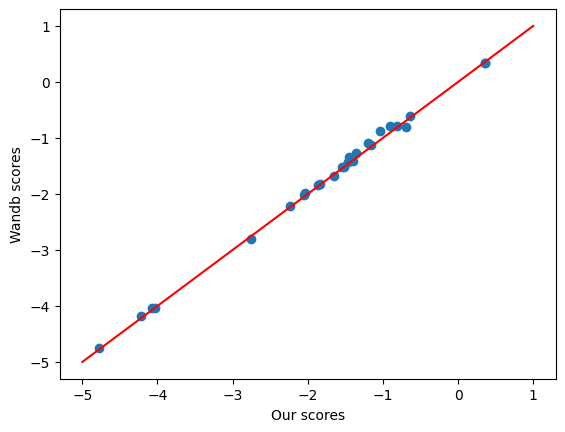

In [33]:
import matplotlib.pyplot as plt
#our_scores_list = [score.item() for score in our_scores_list]
plt.scatter(our_scores_list, wandb_scores_list)
# identity
plt.plot([-5, 1], [-5, 1], color="red")
plt.xlabel("Our scores")
plt.ylabel("Wandb scores")

# Compute the accuracy of the RM
To check I'm doing things right